In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
with open (
    '/Users/treents/project/aiida-cwf/git/acwf-verification-scripts/acwf_paper_plots/plots/common/epsilon-unaries-FHI-aims-vs-Fleur.json'
    ) as f:
    epsilon_data = json.load(f)['unaries']

In [3]:
fhi_aims = epsilon_data['loaded_data']['code_results']['FHI-aims-LDA-tight']['BM_fit_data']
fleur = epsilon_data['loaded_data']['compare_plugin_data']['BM_fit_data']

In [4]:
fleur_residuals = {k: v['residuals'] for k, v in fleur.items()}
fhi_aims_residuals = {k: v['residuals'] for k, v in fhi_aims.items()}

In [5]:
epsilon_values = {}

for config, config_values in epsilon_data['calculated_quantities']['epsilon']['FHI-aims-LDA-tight'].items():
    for element, epsilon in zip(config_values['elements'], config_values['values']):
        epsilon_values[f'{element}-{config}'] = epsilon

Text(0, 0.5, 'Fleur BM fit residuals')

<Figure size 800x400 with 0 Axes>

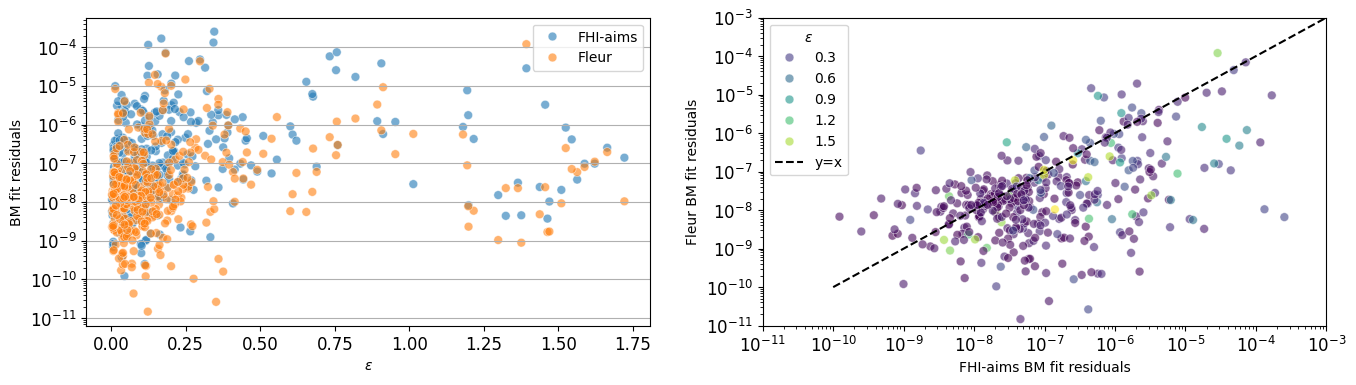

In [6]:
configs = list(epsilon_values.keys())

df = pd.DataFrame({
    'config': configs,
    'FHI-aims': [fhi_aims_residuals[config] for config in configs],
    'Fleur': [fleur_residuals[config] for config in configs],
    'epsilon': [epsilon_values[config] for config in configs]
})

df_melted = df.melt(id_vars=['config', 'epsilon'], value_vars=['FHI-aims', 'Fleur'], var_name='code', value_name='residuals')

plt.figure(figsize=(8, 4))
fig, ax = plt.subplots(ncols=2, figsize=(16, 4))

sns.scatterplot(
    data=df_melted,
    x='epsilon',
    y='residuals',
    hue='code',
    # palette='viridis',
    alpha=0.6,
    s=40,
    ax=ax[0]
)

ax[0].set_xlabel('$\epsilon$')
ax[0].set_ylabel('BM fit residuals')
ax[0].legend(title=None)
# ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].grid(axis='y')

# plt.figure(figsize=(8, 4))
# ax[1].scatter(df['FHI-aims'], df['Fleur'])
sns.scatterplot(
    data=df,
    x='FHI-aims',
    y='Fleur',
    hue='epsilon',
    palette='viridis',
    alpha=0.6,
    s=40,
    ax=ax[1]
)
ax[1].plot([1e-10, 1e-2], [1e-10, 1e-2], color='black', linestyle='--', label='y=x')
ax[1].legend(title='$\epsilon$')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim(1e-11, 1e-3)
ax[1].set_ylim(1e-11, 1e-3)
ax[1].set_xlabel('FHI-aims BM fit residuals')
ax[1].set_ylabel('Fleur BM fit residuals')

In [7]:
df.melt(id_vars=['config', 'epsilon'], value_vars=['FHI-aims', 'Fleur'], var_name='code', value_name='residuals')

,config,epsilon,code,residuals
0,Ac-X/Diamond,0.248889,FHI-aims,4.584519e-07
1,Ag-X/Diamond,0.332793,FHI-aims,1.241037e-09
2,Al-X/Diamond,0.068028,FHI-aims,2.867545e-09
3,Am-X/Diamond,0.284927,FHI-aims,1.116077e-06
4,Ar-X/Diamond,0.600834,FHI-aims,9.045743e-07
...,...,...,...,...
805,Xe-X/SC,0.152537,Fleur,4.886272e-09
806,Y-X/SC,0.134401,Fleur,4.116920e-08
807,Yb-X/SC,1.194395,Fleur,8.888655e-08
808,Zn-X/SC,0.045940,Fleur,1.368221e-08


## Check results from previous paper

In [8]:
code_data_path = Path(
    '/Users/treents/project/aiida-cwf/git/acwf-verification-scripts/acwf_paper_plots/code-data/'
)

with open('../../acwf_paper_plots/code-data/labels.json', 'r') as f:
    labels = json.load(f)


In [9]:
residuals_unaries_oxides = {}

for code_label in labels['methods-main']:
    for unaries_oxides in ['unaries', 'oxides']:
        file = labels['methods-main'][code_label][unaries_oxides]
        with open(code_data_path / file, 'r') as f:
            code_data = json.load(f)
        
        residuals = {k: v['residuals'] if v else None for k, v in code_data['BM_fit_data'].items()}
        residuals_unaries_oxides.setdefault(unaries_oxides, {})[code_label] = residuals

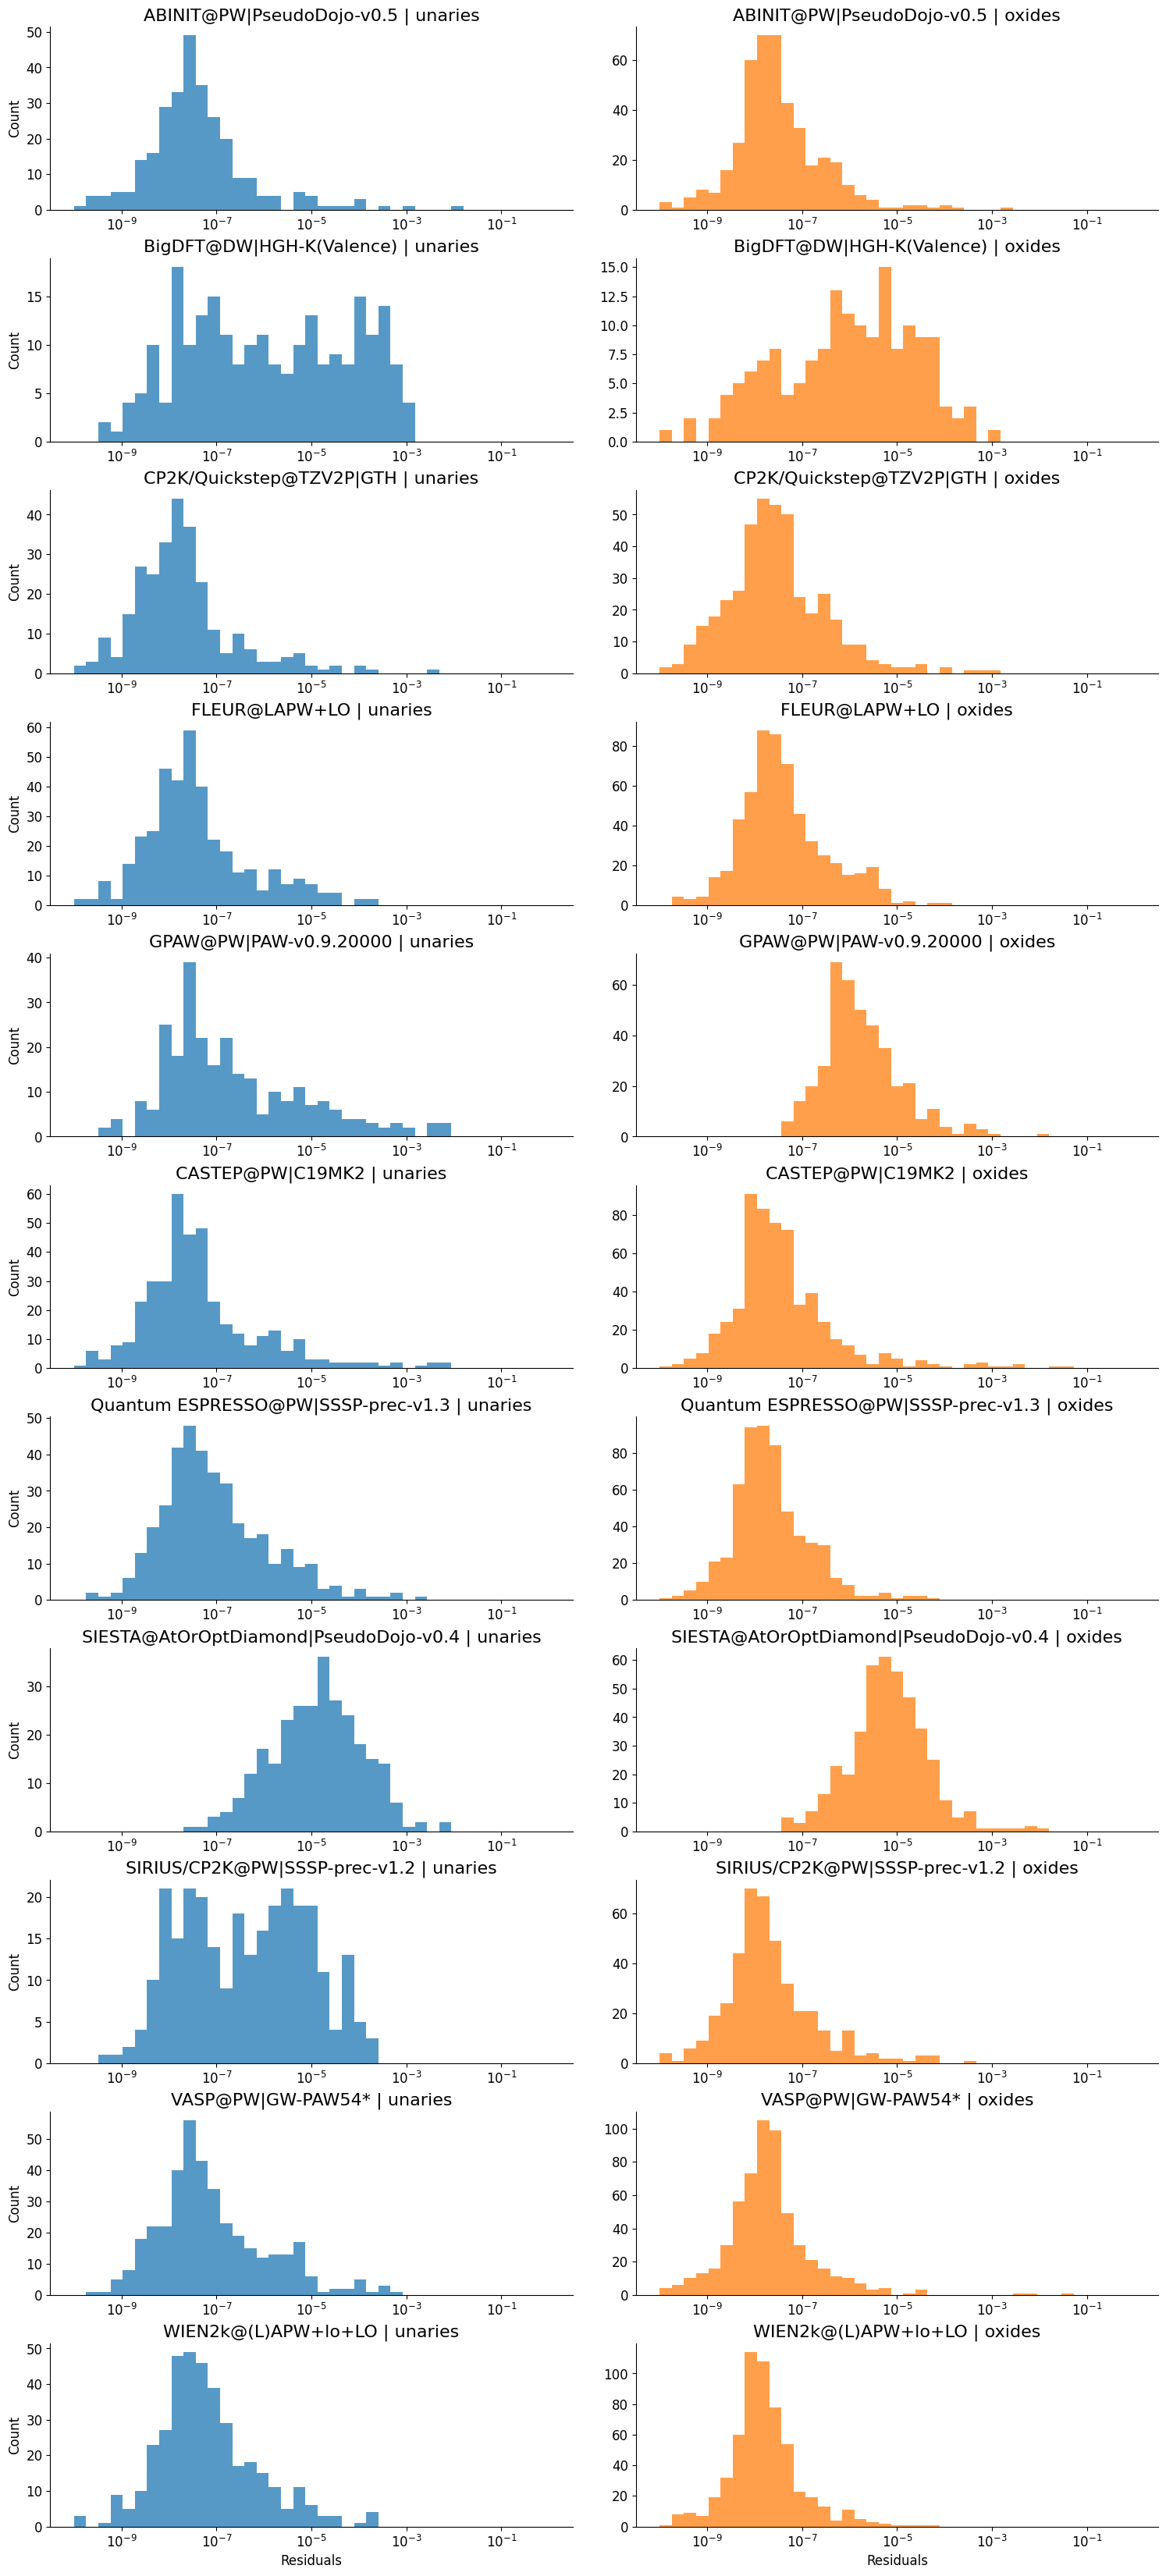

In [10]:
import numpy as np

residuals_unaries_oxides
rows = []
for system, codes_data in residuals_unaries_oxides.items():
    for code, residuals_data in codes_data.items():
        for config, val in residuals_data.items():
            if val is not None:
                rows.append({"system": system, "code": code, "config": config, "residual": val})

df_unaries_oxides = pd.DataFrame(rows)

# Define bins in log space for all subplots
bins_values = np.logspace(-10, 0, 40)

df_unaries_oxides['label_facetgrid'] = df_unaries_oxides['system'] + ' – ' + df_unaries_oxides['code']

g = sns.FacetGrid(
    df_unaries_oxides, 
    # col="label_facetgrid", 
    # col_wrap=4, 
    col='system',
    row='code',
    sharex=False,
    sharey=False,
    height=3,
    aspect=2.5, 
    hue='system'
    )
g.map_dataframe(sns.histplot, x="residual", bins=bins_values)
g.set(xscale="log")
g.set_titles(row_template='{row_name}', col_template='{col_name}', size=16)
g.set_xlabels("Residuals", size=12)
g.set_ylabels("Count", size=12)
# g.fig.subplots_adjust(hspace=0.2, wspace=0.1)

plt.savefig('residuals_nat_rev_physics.pdf')

In [11]:
import itertools
from scipy.stats import ranksums
from scipy.stats import ks_2samp

# Separate unaries and oxides
df_unaries = df_unaries_oxides[df_unaries_oxides["system"] == "unaries"]
df_oxides = df_unaries_oxides[df_unaries_oxides["system"] == "oxides"]

def pairwise_comparisons_ks(df_input):
    codes = sorted(df_input["code"].unique())
    comparisons = []
    for c1, c2 in itertools.combinations(codes, 2):
        data1 = df_input[df_input["code"] == c1]["residual"]
        data2 = df_input[df_input["code"] == c2]["residual"]
        stat, p_value = ks_2samp(data1, data2)
        comparisons.append({"code1": c1.split('@')[0], "code2": c2.split('@')[0], "stat": stat, "p_value": p_value})
    return pd.DataFrame(comparisons)

results_unaries_ks = pairwise_comparisons_ks(df_unaries)
results_oxides_ks = pairwise_comparisons_ks(df_oxides)

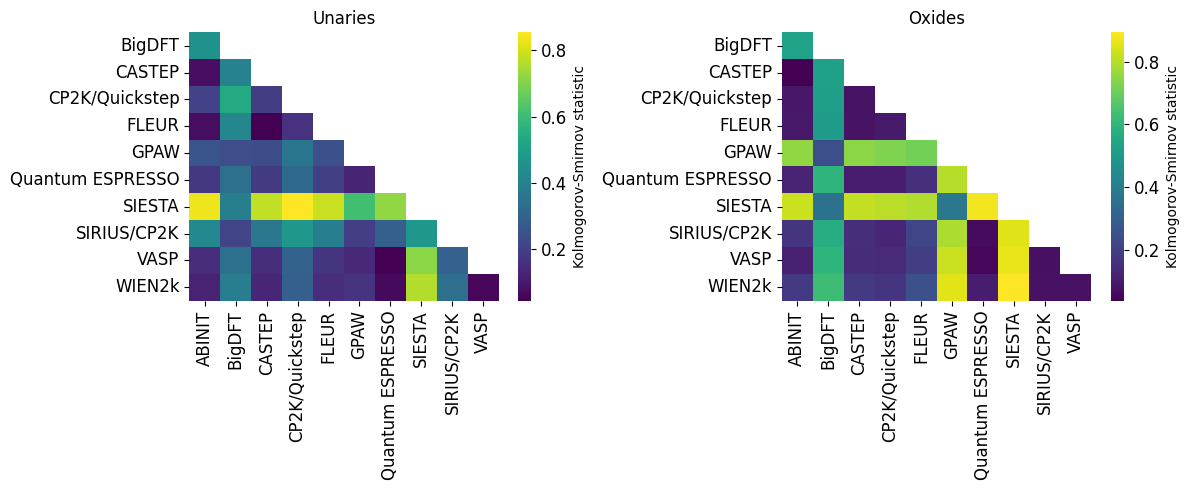

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

df_unaries_pivot = results_unaries_ks.pivot(index='code1', columns='code2', values='stat')

sns.heatmap(df_unaries_pivot.T, ax=axes[0], cmap='viridis', cbar_kws={'label': 'Kolmogorov-Smirnov statistic'})
axes[0].set_title("Unaries")
axes[0].set(xlabel='', ylabel='')

df_oxides_pivot = results_oxides_ks.pivot(index='code1', columns='code2', values='stat')
sns.heatmap(df_oxides_pivot.T, ax=axes[1], cmap='viridis', cbar_kws={'label': 'Kolmogorov-Smirnov statistic'})
axes[1].set_title("Oxides")
axes[1].set(xlabel='', ylabel='')

plt.tight_layout()
plt.savefig('nat_rev_physics_residuals_pairwise_distributions.png', dpi=300)